In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import tensorflow
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

In [10]:
DATA_DIR = "seg1-2"

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [11]:
import os
import cv2
import numpy as np
import albumentations as A

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

def get_validation_augmentation(target_height=320, target_width=320):
    """
    Pad if needed, then resize to (target_height x target_width).
    Preserves aspect ratio better and makes later resizing safer.

    Args:
        target_height (int): Desired height of final image
        target_width (int): Desired width of final image
    """
    test_transform = [
        A.PadIfNeeded(min_height=target_height, min_width=target_width, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Resize(height=target_height, width=target_width),
    ]
    return A.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform"""
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

class Dataset:
    """General dataset with optional segmentation mask support."""
    
    CLASSES = ['crack']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            classes=['crack'], 
            augmentation=None, 
            preprocessing=None,
    ):
        self.list_img = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, img_id) for img_id in self.list_img]
        
        if masks_dir and os.path.exists(masks_dir):
            self.has_masks = True
            self.list_mask = sorted(os.listdir(masks_dir))
            self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.list_mask]
        else:
            self.has_masks = False
            self.masks_fps = None
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes] if classes else []
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # Read image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read mask if exists
        if self.has_masks:
            mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
            
            if mask.shape[-1] != 1:
                background = 1 - mask.sum(axis=-1, keepdims=True)
                mask = np.concatenate((mask, background), axis=-1)
        else:
            mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.float32)  # Dummy mask
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
        
    def __len__(self):
        return len(self.list_img)


In [12]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['crack']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


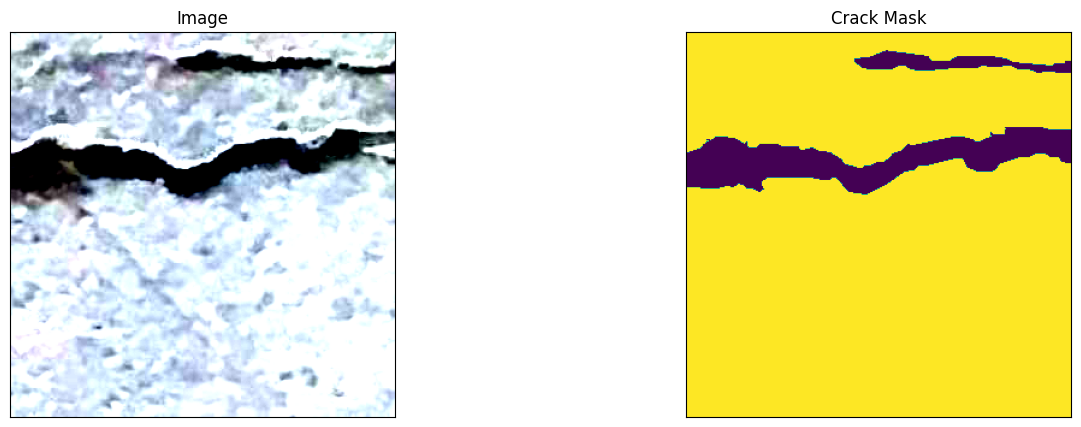

(320, 320, 3)


In [14]:
# Lets look at data we have
dataset = Dataset(x_test_dir, y_test_dir, classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),)

image, mask = dataset[23] # get some sample
visualize(
    image=image, 
    crack_mask=mask[..., 0].squeeze()
)
print(image.shape)

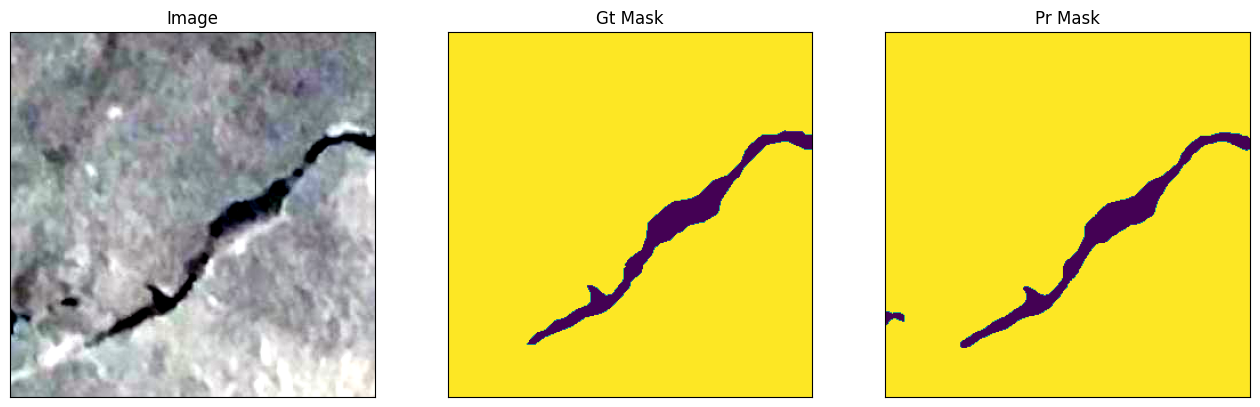

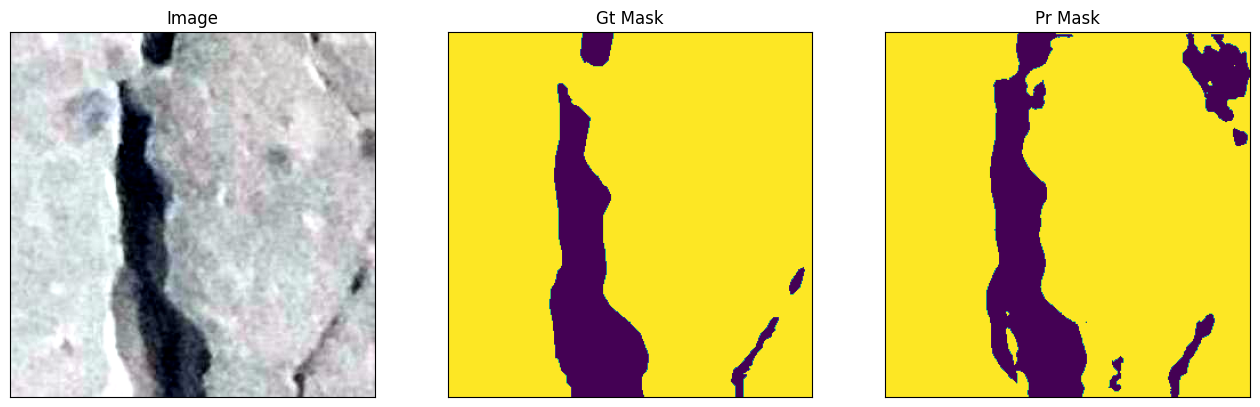

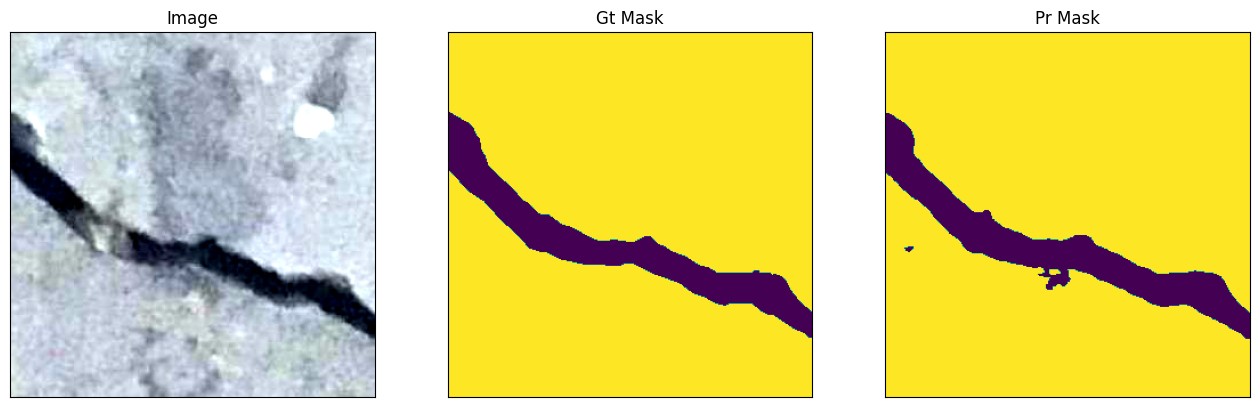

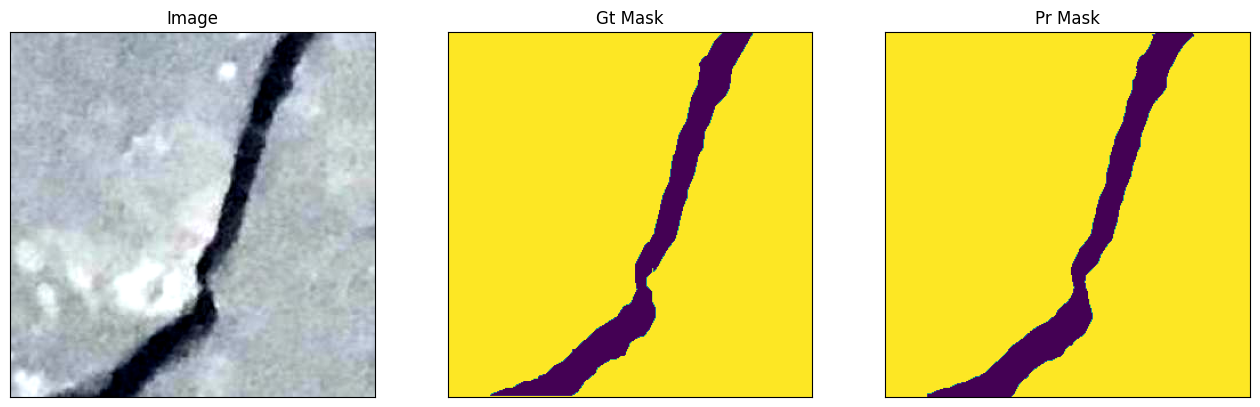

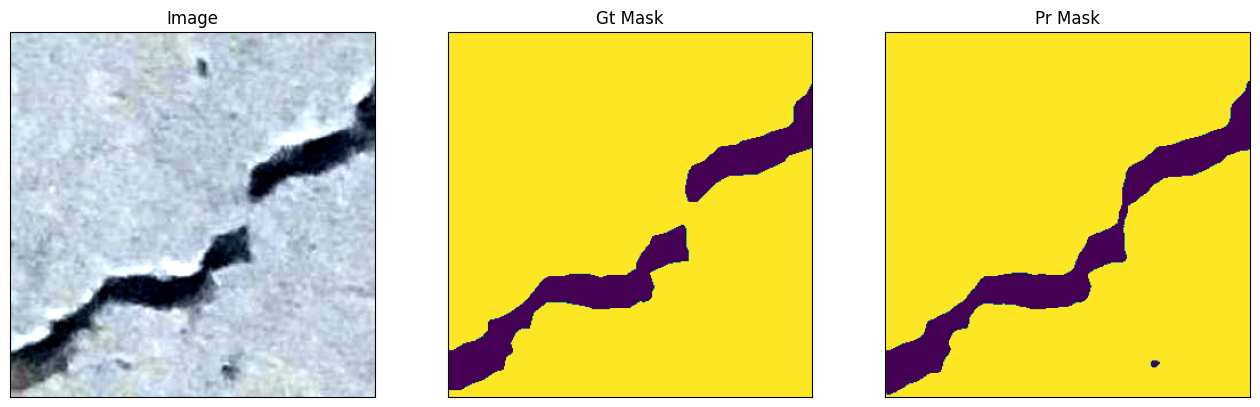

In [15]:
model.load_weights('best_model.h5') 
n = 5
ids = np.arange(n)

for i in ids:
    
    image, gt_mask = dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )